In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
from functools import reduce
import jax.numpy as jnp
import jax.random as random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, HMCECS
import numpyro_glm
import numpyro_glm.metric.models as glm_metric
from scipy.stats import pearsonr

# Chapter 18: Metric Predicted Variable with Multiple Metric Predictors
## Multiple Linear Regression

In [3]:
df_SAT = pd.read_csv('datasets/Guber1999data.csv')
df_SAT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      50 non-null     object 
 1   Spend      50 non-null     float64
 2   StuTeaRat  50 non-null     float64
 3   Salary     50 non-null     float64
 4   PrcntTake  50 non-null     int64  
 5   SATV       50 non-null     int64  
 6   SATM       50 non-null     int64  
 7   SATT       50 non-null     int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [4]:
df_SAT.describe()

,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.905260,16.858000,34.828920,35.240000,457.140000,508.780000,965.920000
std,1.362807,2.266355,5.941265,26.762417,35.175948,40.204726,74.820558
min,3.656000,13.800000,25.994000,4.000000,401.000000,443.000000,844.000000
25%,4.881750,15.225000,30.977500,9.000000,427.250000,474.750000,897.250000
50%,5.767500,16.600000,33.287500,28.000000,448.000000,497.500000,945.500000
75%,6.434000,17.575000,38.545750,63.000000,490.250000,539.500000,1032.000000
max,9.774000,24.300000,50.045000,81.000000,516.000000,592.000000,1107.000000


In [5]:
y_SAT = df_SAT.SATT.values
x_SAT_names = ['Spend', 'PrcntTake']
x_SAT = df_SAT[x_SAT_names].values

df_SAT[x_SAT_names].corr()

,Spend,PrcntTake
Spend,1.000000,0.592627
PrcntTake,0.592627,1.000000


In [6]:
key = random.PRNGKey(0)
model = NUTS(glm_metric.multi_metric_predictors_robust)
mcmc = MCMC(model, num_warmup=1000, num_samples=20000)
mcmc.run(key, y_SAT, x_SAT)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        nu     34.09     29.42     25.30      2.31     72.56  19618.01      1.00
     zb[0]      0.23      0.08      0.23      0.10      0.36  15862.99      1.00
     zb[1]     -1.03      0.08     -1.03     -1.16     -0.90  16736.26      1.00
       zb0     -0.00      0.06     -0.00     -0.11      0.10  20819.97      1.00
    zsigma      0.43      0.05      0.42      0.34      0.51  19435.75      1.00

Number of divergences: 0


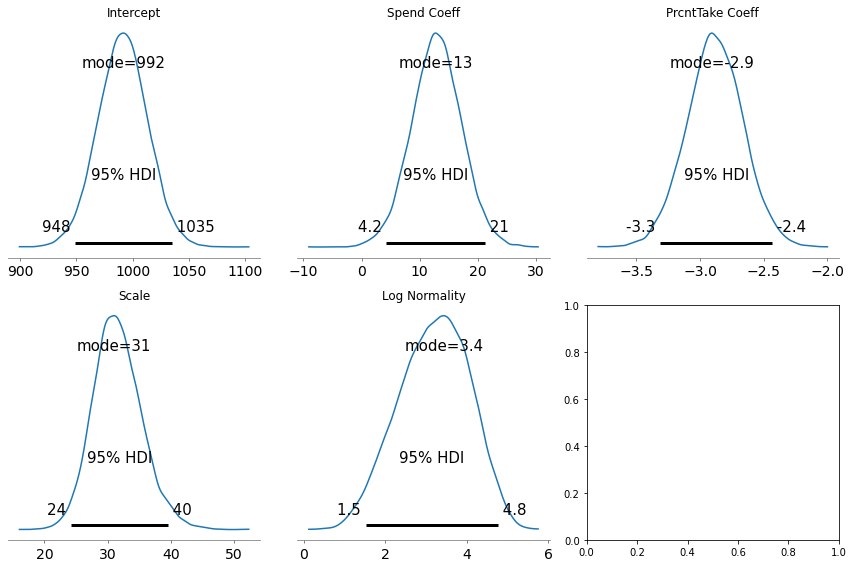

In [7]:
idata_SAT = az.from_numpyro(
    mcmc,
    coords=dict(predictors=[0, 1]),
    dims=dict(b_=['predictors']))
posterior_SAT = idata_SAT.posterior

fig_SAT_posteriors, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
to_plot_posteriors_SAT = {
    'Intercept': posterior_SAT['b0'].values.flatten(),
    'Spend Coeff': posterior_SAT['b_'].sel(dict(predictors=0)).values.flatten(),
    'PrcntTake Coeff': posterior_SAT['b_'].sel(dict(predictors=1)).values.flatten(),
    'Scale': posterior_SAT['sigma'].values.flatten(),
    'Log Normality': np.log(posterior_SAT['nu'].values.flatten()),
}

for ax, (title, values) in zip(axes.flatten(), to_plot_posteriors_SAT.items()):
    az.plot_posterior(values, point_estimate='mode', hdi_prob=0.95, ax=ax)
    ax.set_title(title)

fig_SAT_posteriors.tight_layout()

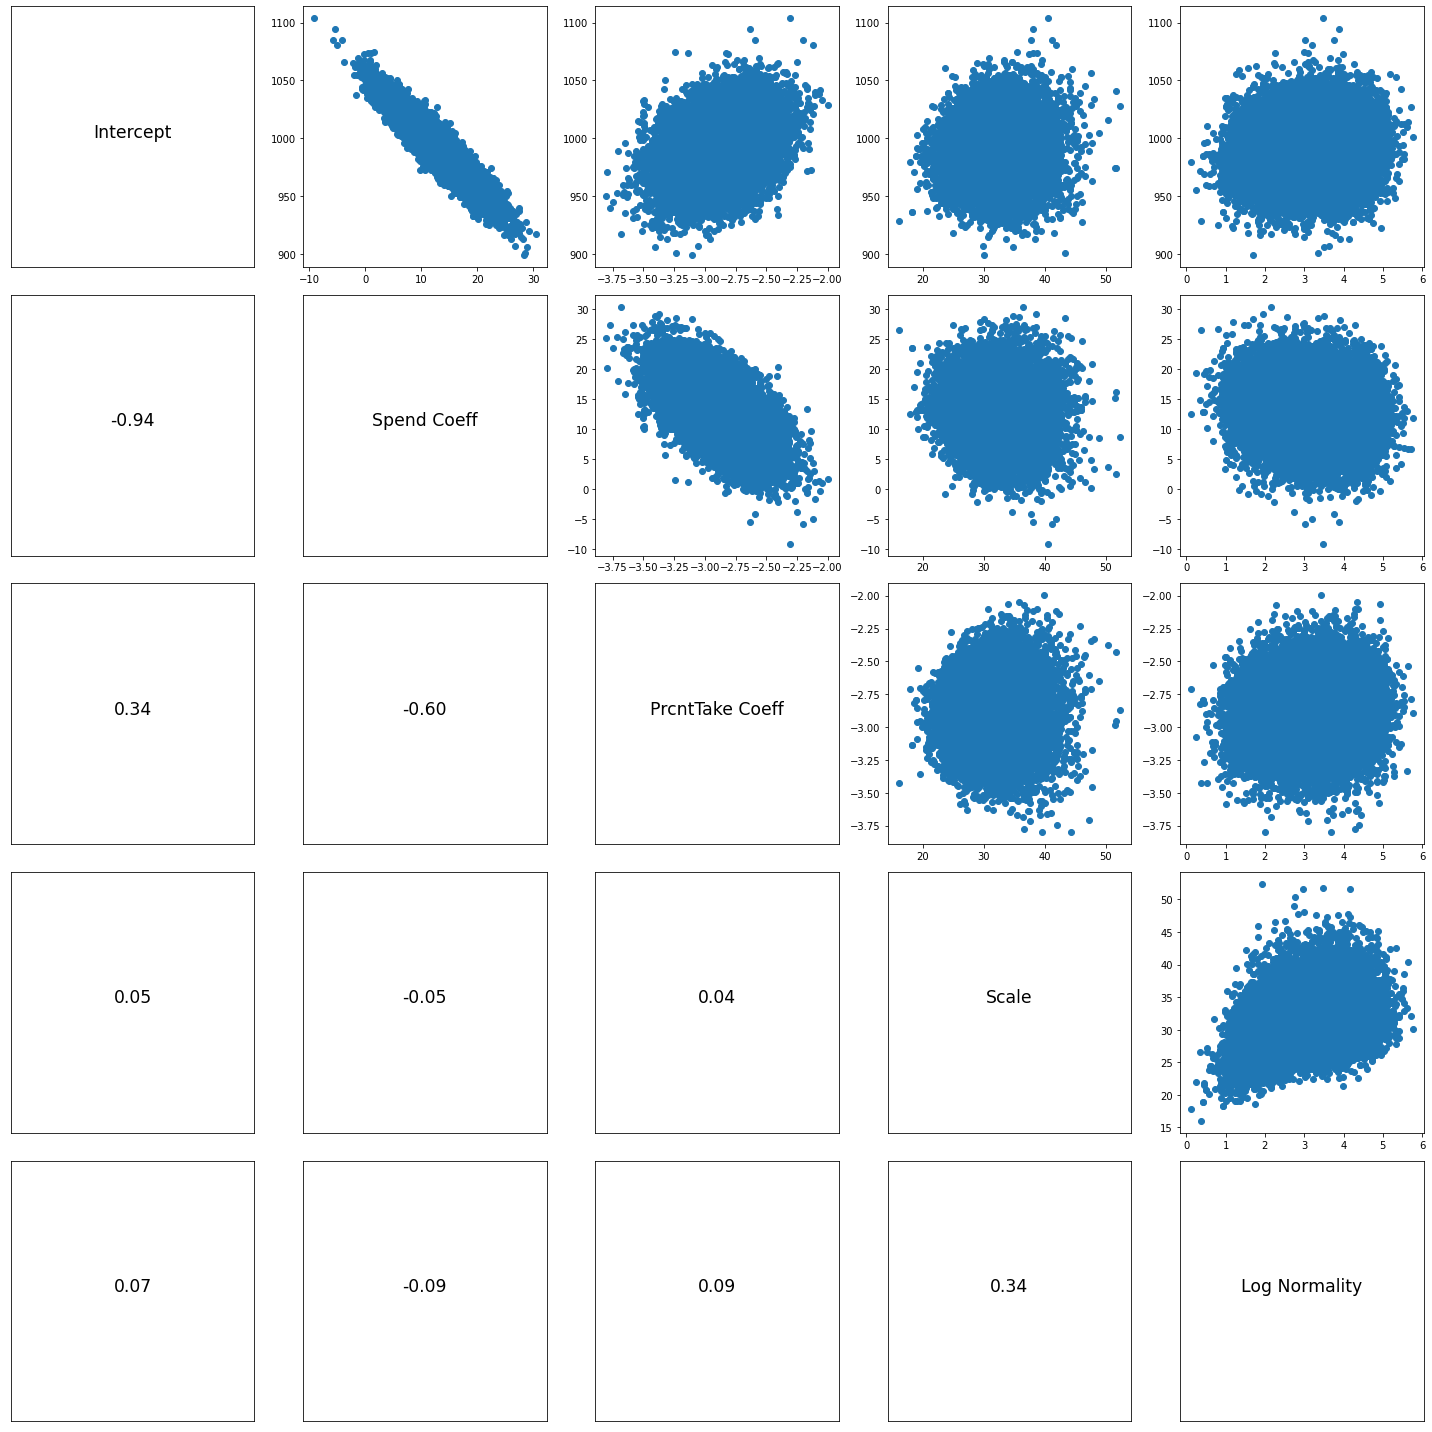

In [8]:
fig_SAT_pairwise_scatter, axes = plt.subplots(
    nrows=5, ncols=5, figsize=(20, 20))

for ith, ith_var in enumerate(to_plot_posteriors_SAT.keys()):
    for jth, jth_var in enumerate(to_plot_posteriors_SAT.keys()):
        ax = axes[jth, ith]

        if ith == jth:
            numpyro_glm.plot_text(ith_var, ax)
        elif ith < jth:
            ith_var_data = to_plot_posteriors_SAT[ith_var]
            jth_var_data = to_plot_posteriors_SAT[jth_var]

            corr, _ = pearsonr(ith_var_data, jth_var_data)
            numpyro_glm.plot_text(f'{corr:.2f}', ax)
        else:
            ith_var_data = to_plot_posteriors_SAT[ith_var]
            jth_var_data = to_plot_posteriors_SAT[jth_var]

            ax.scatter(ith_var_data, jth_var_data)

fig_SAT_pairwise_scatter.tight_layout()

## Multiplicative Interaction of Metric Predictors

In [9]:
df_SAT['Spend_Prcnt'] = df_SAT['Spend'] * df_SAT['PrcntTake']
x_SAT_names = ['Spend', 'PrcntTake', 'Spend_Prcnt']
x_SAT_multiplicative = df_SAT[x_SAT_names].values

df_SAT[x_SAT_names].corr()

,Spend,PrcntTake,Spend_Prcnt
Spend,1.000000,0.592627,0.775025
PrcntTake,0.592627,1.000000,0.951146
Spend_Prcnt,0.775025,0.951146,1.000000


In [10]:
key = random.PRNGKey(0)
model = NUTS(glm_metric.multi_metric_predictors_robust)
mcmc = MCMC(model, num_warmup=1000, num_samples=20000)
mcmc.run(key, y_SAT, x_SAT_multiplicative)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        nu     35.95     30.26     26.95      2.58     76.03  13713.37      1.00
     zb[0]      0.03      0.15      0.03     -0.22      0.26   7987.84      1.00
     zb[1]     -1.51      0.30     -1.50     -2.01     -1.03   7843.39      1.00
     zb[2]      0.63      0.38      0.63      0.03      1.28   7281.11      1.00
       zb0     -0.00      0.06     -0.00     -0.10      0.10  14566.92      1.00
    zsigma      0.42      0.05      0.42      0.34      0.50  11687.80      1.00

Number of divergences: 0


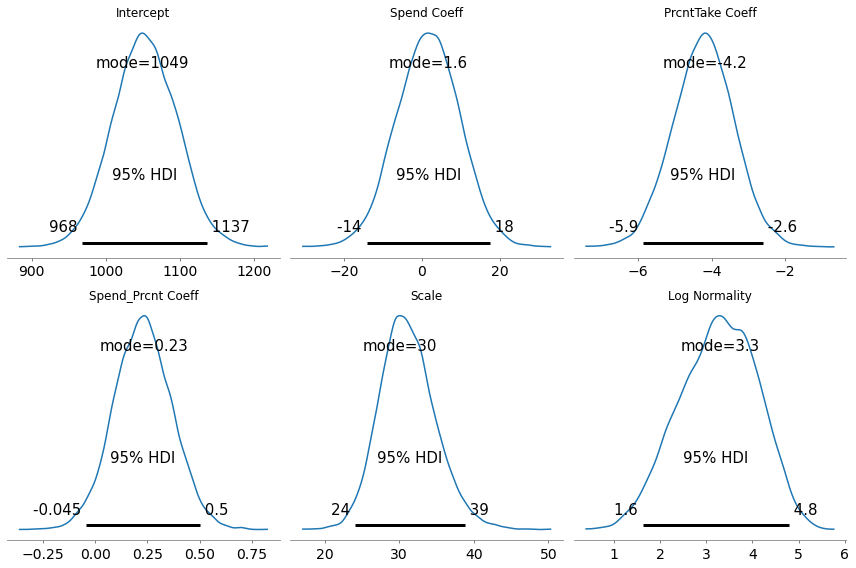

In [11]:
idata_SAT_multiplicative = az.from_numpyro(
    mcmc,
    coords=dict(predictors=[0, 1, 2]),
    dims=dict(b_=['predictors']))
posterior_SAT_multiplicative = idata_SAT_multiplicative.posterior

fig_SAT_multiplicative_posteriors, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8))
to_plot_posteriors_SAT_multiplicative = {
    'Intercept': posterior_SAT_multiplicative['b0'].values.flatten(),
    'Spend Coeff': posterior_SAT_multiplicative['b_'].sel(dict(predictors=0)).values.flatten(),
    'PrcntTake Coeff': posterior_SAT_multiplicative['b_'].sel(dict(predictors=1)).values.flatten(),
    'Spend_Prcnt Coeff': posterior_SAT_multiplicative['b_'].sel(dict(predictors=2)).values.flatten(),
    'Scale': posterior_SAT_multiplicative['sigma'].values.flatten(),
    'Log Normality': np.log(posterior_SAT_multiplicative['nu'].values.flatten()),
}

for ax, (title, values) in zip(axes.flatten(), to_plot_posteriors_SAT_multiplicative.items()):
    az.plot_posterior(values, point_estimate='mode', hdi_prob=0.95, ax=ax)
    ax.set_title(title)

fig_SAT_multiplicative_posteriors.tight_layout()

/usr/share/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  
/usr/share/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


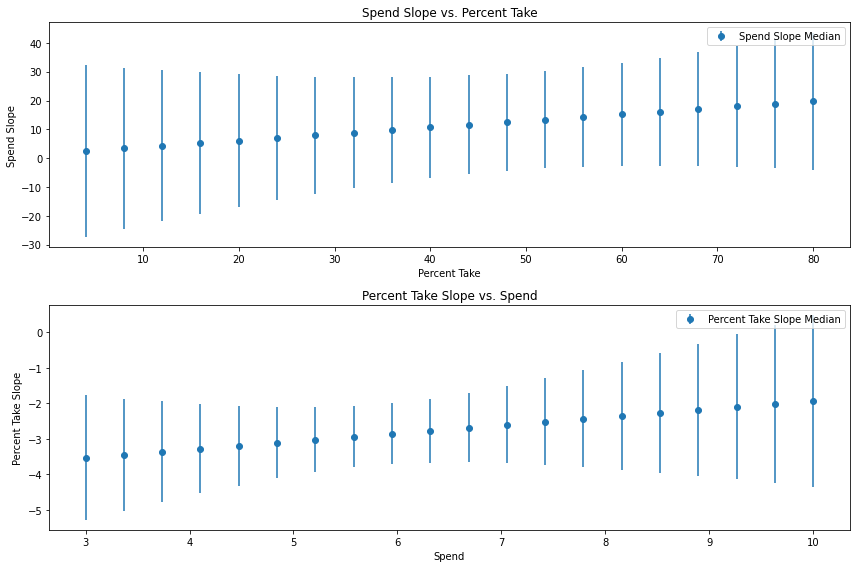

In [12]:
fig_SAT_slopes, axes = plt.subplots(nrows=2, figsize=(12, 8))

# Spend as a function of Percent Take.
ax = axes[0]
percent_take = np.linspace(4, 80, 20)
spend_slopes = (to_plot_posteriors_SAT_multiplicative['Spend Coeff'].reshape(-1, 1)
                + to_plot_posteriors_SAT_multiplicative['Spend_Prcnt Coeff'].reshape(-1, 1) * percent_take.reshape(1, -1))
spend_hdis = az.hdi(spend_slopes, hdi_prob=0.95)
spend_medians = np.median(spend_slopes, axis=0)

ax.errorbar(percent_take, spend_medians,
            yerr=spend_hdis[:, 0] - spend_hdis[:, 1], fmt='o', label='Spend Slope Median')
ax.set_title('Spend Slope vs. Percent Take')
ax.set_xlabel('Percent Take')
ax.set_ylabel('Spend Slope')
ax.legend()

# Percent Take as a function of Spend.
ax = axes[1]
spend = np.linspace(3, 10, 20)
prcnt_slopes = (to_plot_posteriors_SAT_multiplicative['PrcntTake Coeff'].reshape(-1, 1)
                + to_plot_posteriors_SAT_multiplicative['Spend_Prcnt Coeff'].reshape(-1, 1) * spend.reshape(1, -1))
prcnt_hdis = az.hdi(prcnt_slopes, hdi_prob=0.95)
prcnt_medians = np.median(prcnt_slopes, axis=0)

ax.errorbar(spend, prcnt_medians,
            yerr=prcnt_hdis[:, 0] - prcnt_hdis[:, 1], fmt='o', label='Percent Take Slope Median')
ax.set_title('Percent Take Slope vs. Spend')
ax.set_xlabel('Spend')
ax.set_ylabel('Percent Take Slope')
ax.legend()

fig_SAT_slopes.tight_layout()

## Shrinkage of Regression Coefficients
### Without Shrinkage Model

In [13]:
def normalize(values):
    return (values - np.mean(values)) / np.std(values)


nb_random_preds = 12

df_SAT_random = df_SAT.copy()
for i in range(nb_random_preds):
    df_SAT_random[f'xRand{i}'] = normalize(
        np.random.normal(0, 1, size=len(df_SAT)))

df_SAT_random.describe()

,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT,Spend_Prcnt,xRand0,xRand1,xRand2,xRand3,xRand4,xRand5,xRand6,xRand7,xRand8,xRand9,xRand10,xRand11
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,5.905260,16.858000,34.828920,35.240000,457.140000,508.780000,965.920000,229.283380,1.776357e-17,1.013079e-17,-1.221245e-17,-6.661338e-18,-2.664535e-17,-2.220446e-18,1.110223e-18,1.332268e-17,-1.776357e-17,-3.552714e-17,2.886580e-17,-1.332268e-17
std,1.362807,2.266355,5.941265,26.762417,35.175948,40.204726,74.820558,206.179695,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00
min,3.656000,13.800000,25.994000,4.000000,401.000000,443.000000,844.000000,14.624000,-2.836879e+00,-2.655150e+00,-1.788008e+00,-2.198380e+00,-1.753570e+00,-2.430538e+00,-2.544658e+00,-2.180803e+00,-2.321034e+00,-2.037730e+00,-2.172055e+00,-2.305398e+00
25%,4.881750,15.225000,30.977500,9.000000,427.250000,474.750000,897.250000,52.845750,-6.202360e-01,-5.076216e-01,-7.927381e-01,-6.081692e-01,-7.336870e-01,-7.497249e-01,-5.006603e-01,-6.751623e-01,-5.799934e-01,-5.239336e-01,-7.401798e-01,-7.530080e-01
50%,5.767500,16.600000,33.287500,28.000000,448.000000,497.500000,945.500000,148.263000,2.358080e-02,5.158018e-02,-6.962515e-02,8.171091e-02,-6.355309e-02,1.707366e-01,1.772477e-02,2.645897e-03,6.081579e-03,1.161016e-01,5.487160e-02,7.811469e-02
75%,6.434000,17.575000,38.545750,63.000000,490.250000,539.500000,1032.000000,346.398250,4.339206e-01,6.523665e-01,6.679811e-01,6.267902e-01,5.757534e-01,5.890503e-01,7.075468e-01,6.141276e-01,5.156524e-01,5.762328e-01,5.047367e-01,8.810784e-01
max,9.774000,24.300000,50.045000,81.000000,516.000000,592.000000,1107.000000,714.177000,2.351943e+00,2.473485e+00,2.404850e+00,2.194185e+00,2.881815e+00,1.816643e+00,1.812556e+00,2.208210e+00,2.464095e+00,2.972318e+00,2.202341e+00,1.508188e+00


In [14]:
x_SAT_random_cols = ['Spend', 'PrcntTake',
                     *(f'xRand{i}' for i in range(nb_random_preds))]

x_SAT_random = df_SAT_random[x_SAT_random_cols].values
y_SAT_random = df_SAT_random['SATT'].values

key = random.PRNGKey(0)
kernel = NUTS(glm_metric.multi_metric_predictors_robust)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000)
mcmc.run(key, y_SAT_random, x_SAT_random)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        nu     37.14     30.33     28.46      2.46     77.12  19630.21      1.00
     zb[0]      0.26      0.09      0.26      0.12      0.41  14190.15      1.00
     zb[1]     -1.04      0.10     -1.04     -1.20     -0.88  13016.40      1.00
     zb[2]     -0.05      0.08     -0.05     -0.18      0.07  15886.22      1.00
     zb[3]      0.07      0.07      0.07     -0.05      0.19  16439.15      1.00
     zb[4]     -0.11      0.07     -0.11     -0.23      0.01  18684.52      1.00
     zb[5]     -0.01      0.07     -0.01     -0.13      0.09  17409.55      1.00
     zb[6]     -0.10      0.07     -0.10     -0.21      0.02  19546.49      1.00
     zb[7]      0.00      0.07      0.00     -0.12      0.12  15457.77      1.00
     zb[8]     -0.05      0.07     -0.05     -0.16      0.06  19161.10      1.00
     zb[9]     -0.08      0.07     -0.08     -0.21      0.04  18176.02      1.00
    zb[10]     -0.01      0

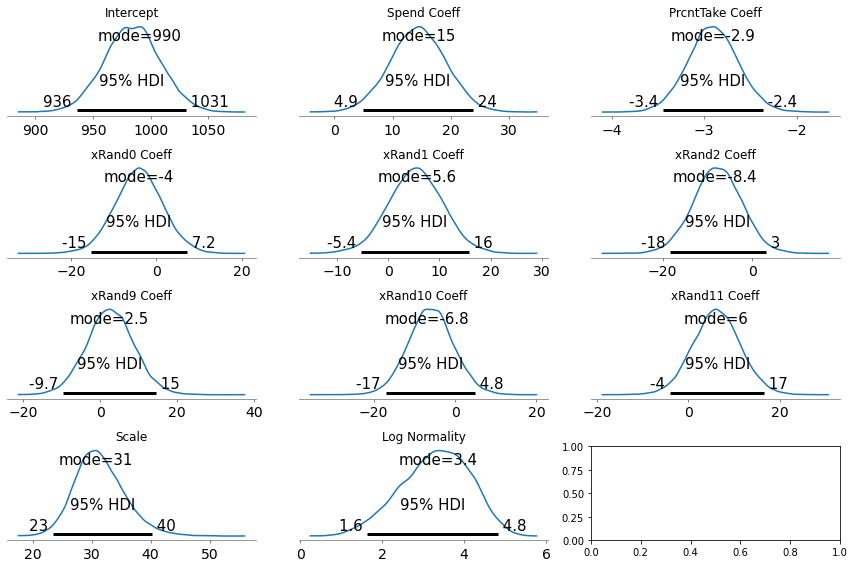

In [15]:
idata_SAT_random = az.from_numpyro(
    mcmc,
    coords=dict(predictors=list(range(14))),
    dims=dict(b_=['predictors']))
posterior_SAT_random = idata_SAT_random.posterior

fig_SAT_random_posteriors, axes = plt.subplots(
    nrows=4, ncols=3, figsize=(12, 8))
to_plot_posteriors_SAT_random = {
    'Intercept': posterior_SAT_random['b0'].values.flatten(),
    'Spend Coeff': posterior_SAT_random['b_'].sel(dict(predictors=0)).values.flatten(),
    'PrcntTake Coeff': posterior_SAT_random['b_'].sel(dict(predictors=1)).values.flatten(),
    **{f'xRand{i} Coeff': posterior_SAT_random['b_'].sel(dict(predictors=i + 2)).values.flatten()
        for i in [0, 1, 2, 9, 10, 11]},
    'Scale': posterior_SAT_random['sigma'].values.flatten(),
    'Log Normality': np.log(posterior_SAT_random['nu'].values.flatten()),
}

for ax, (title, values) in zip(axes.flatten(), to_plot_posteriors_SAT_random.items()):
    az.plot_posterior(values, point_estimate='mode', hdi_prob=0.95, ax=ax)
    ax.set_title(title)

fig_SAT_random_posteriors.tight_layout()

### Shrinkage Model

In [16]:
key = random.PRNGKey(0)
kernel = NUTS(glm_metric.multi_metric_predictors_robust_with_shrinkage)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000)
mcmc.run(key, y_SAT_random, x_SAT_random)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        nu     36.52     30.66     27.64      2.26     76.58  10166.20      1.00
  sigma_b_      0.04      0.03      0.04      0.01      0.08   4236.02      1.00
       zb0      0.00      0.06      0.00     -0.10      0.10  11841.24      1.00
    zb_[0]      0.15      0.10      0.15     -0.01      0.29   5413.59      1.00
    zb_[1]     -0.97      0.09     -0.97     -1.13     -0.82   6743.53      1.00
    zb_[2]     -0.03      0.05     -0.02     -0.11      0.04   9054.24      1.00
    zb_[3]      0.02      0.04      0.01     -0.05      0.10  10385.39      1.00
    zb_[4]     -0.04      0.05     -0.03     -0.12      0.04   8339.71      1.00
    zb_[5]     -0.00      0.04     -0.00     -0.07      0.06  16971.99      1.00
    zb_[6]     -0.04      0.05     -0.03     -0.12      0.04   8758.09      1.00
    zb_[7]      0.00      0.04      0.00     -0.06      0.07  16889.08      1.00
    zb_[8]     -0.02      0

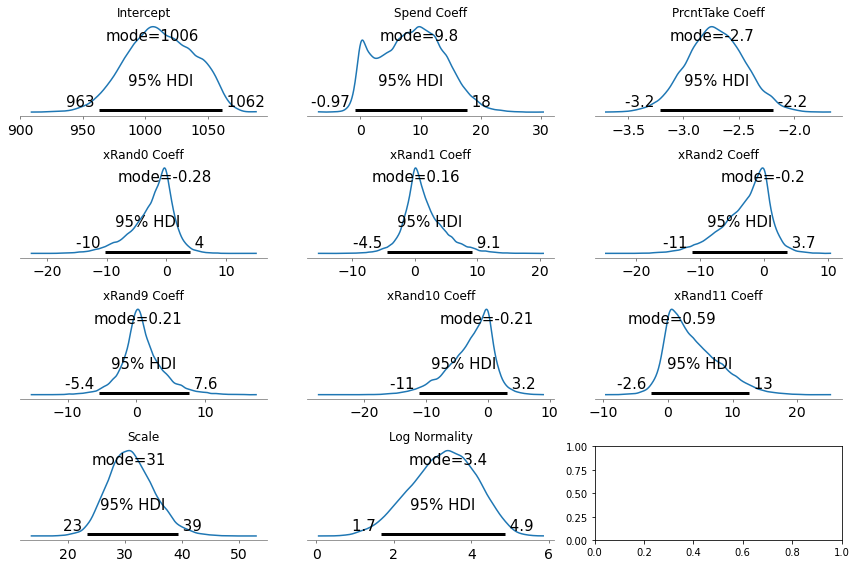

In [17]:
idata_SAT_random_shrinkage = az.from_numpyro(
    mcmc,
    coords=dict(predictors=list(range(14))),
    dims=dict(b_=['predictors']))
posterior_SAT_random_shrinkage = idata_SAT_random_shrinkage.posterior

fig_SAT_random_posteriors_shrinkage, axes = plt.subplots(
    nrows=4, ncols=3, figsize=(12, 8))
to_plot_posteriors_SAT_random_shrinkage = {
    'Intercept': posterior_SAT_random_shrinkage['b0'].values.flatten(),
    'Spend Coeff': posterior_SAT_random_shrinkage['b_'].sel(dict(predictors=0)).values.flatten(),
    'PrcntTake Coeff': posterior_SAT_random_shrinkage['b_'].sel(dict(predictors=1)).values.flatten(),
    **{f'xRand{i} Coeff': posterior_SAT_random_shrinkage['b_'].sel(dict(predictors=i + 2)).values.flatten()
        for i in [0, 1, 2, 9, 10, 11]},
    'Scale': posterior_SAT_random_shrinkage['sigma'].values.flatten(),
    'Log Normality': np.log(posterior_SAT_random_shrinkage['nu'].values.flatten()),
}

for ax, (title, values) in zip(axes.flatten(), to_plot_posteriors_SAT_random_shrinkage.items()):
    az.plot_posterior(values, point_estimate='mode', hdi_prob=0.95, ax=ax)
    ax.set_title(title)

fig_SAT_random_posteriors_shrinkage.tight_layout()

## Variable Selection

In [18]:
x_SAT_all_names = ['Spend', 'StuTeaRat', 'Salary', 'PrcntTake']
x_SAT_all = df_SAT[x_SAT_all_names].values

key = random.PRNGKey(0)
kernel = DiscreteHMCGibbs(
    NUTS(glm_metric.multi_metric_predictors_robust_with_selection), modified=True)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=40000)
mcmc.run(key, y_SAT, x_SAT_all)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  delta[0]      0.59      0.49      1.00      0.00      1.00   1517.28      1.00
  delta[1]      0.18      0.38      0.00      0.00      1.00   4396.67      1.00
  delta[2]      0.22      0.41      0.00      0.00      1.00   2954.29      1.00
  delta[3]      1.00      0.00      1.00      1.00      1.00       nan       nan
        nu     35.95     30.77     26.92      2.15     76.20  20289.71      1.00
    sigmab      2.38      3.58      1.18      0.04      5.57   1577.88      1.00
       zb0     -0.00      0.07     -0.00     -0.11      0.10  20406.51      1.00
    zb_[0]      1.77     27.99      0.21     -6.60      6.22    216.50      1.00
    zb_[1]      1.03     18.89     -0.08    -12.82     11.96   1978.29      1.00
    zb_[2]     -0.47     18.87      0.10    -10.54     10.89   1368.16      1.00
    zb_[3]     -0.98      0.10     -0.99     -1.14     -0.82   3597.67      1.00
    zsigma      0.44      0

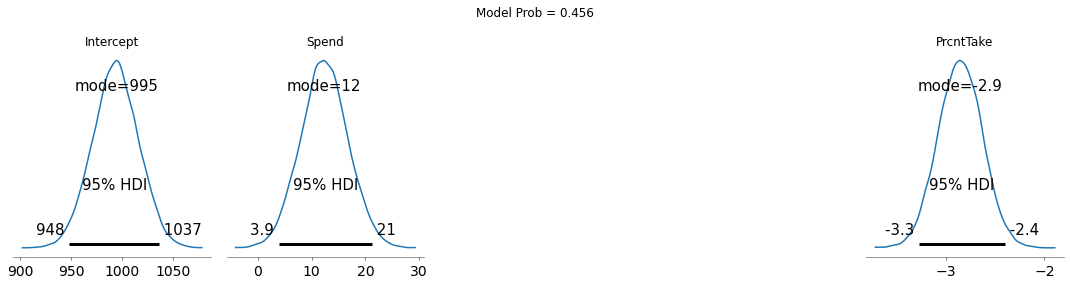

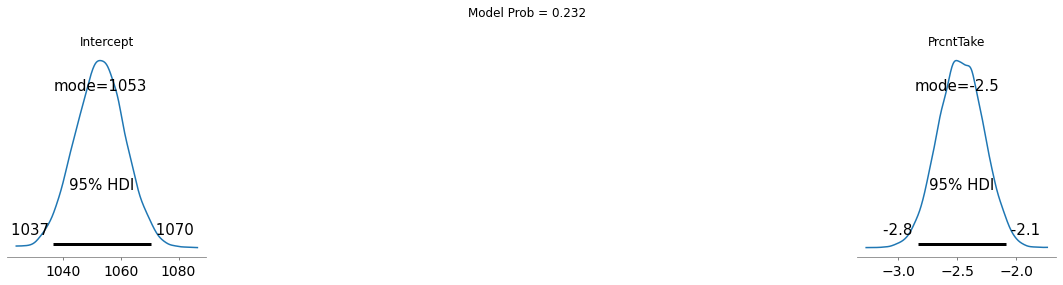

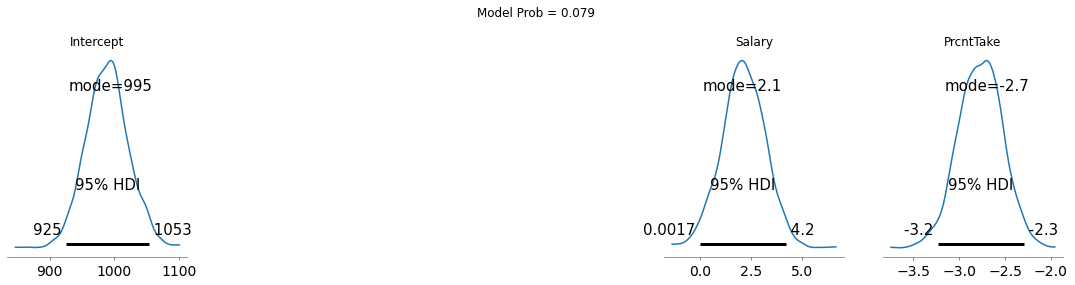

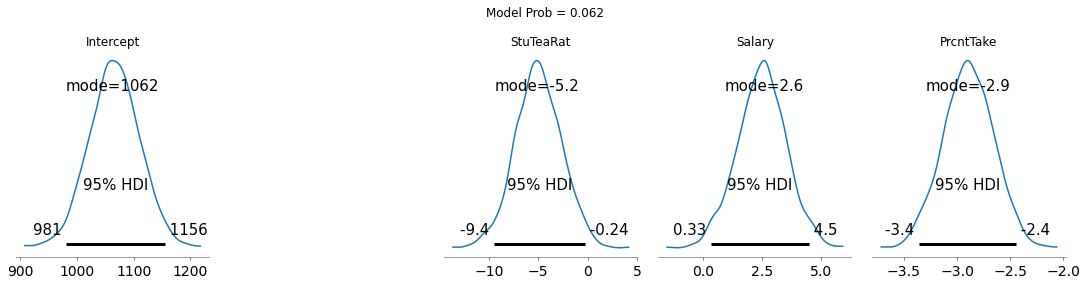

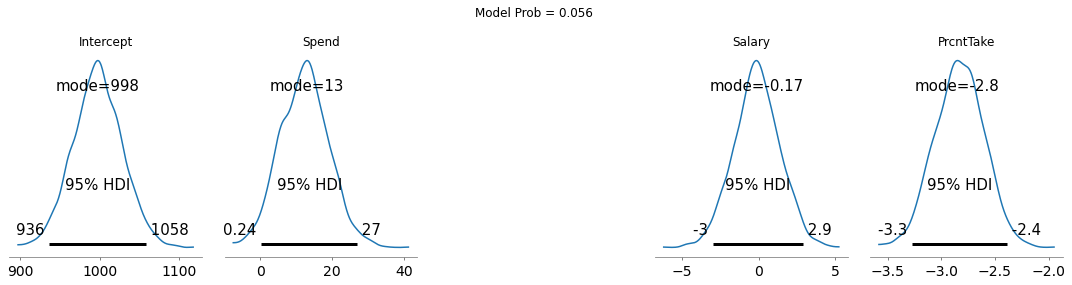

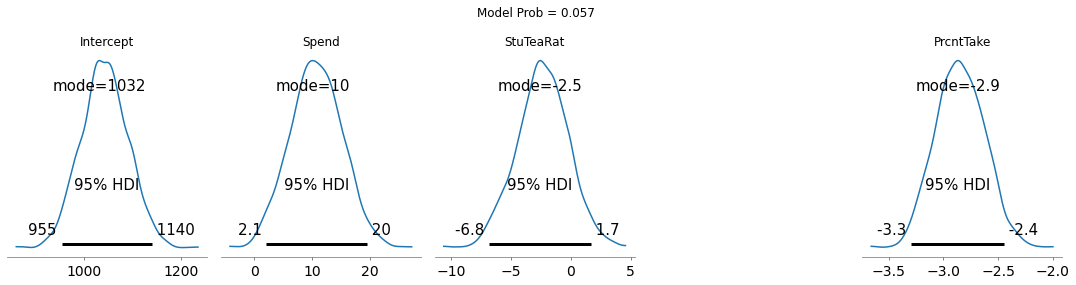

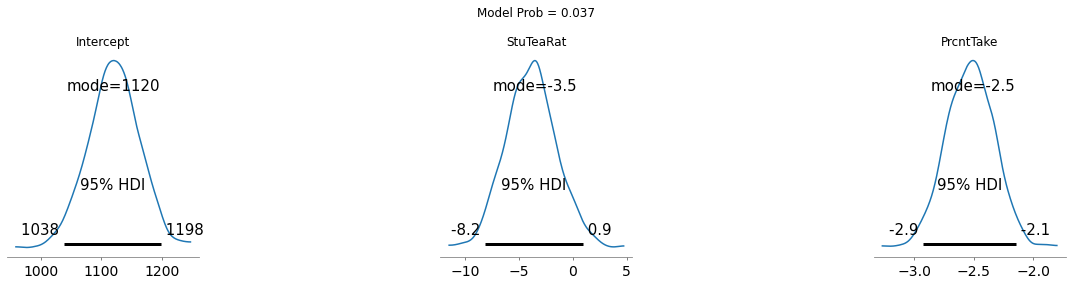

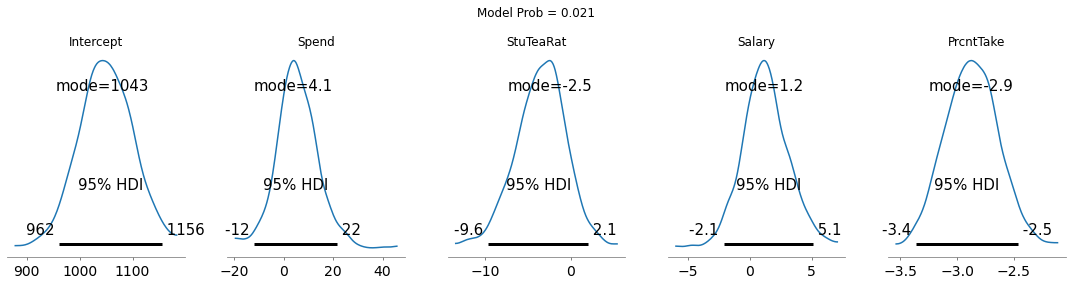

In [19]:
idata_SAT_all_with_selection = az.from_numpyro(
    mcmc,
    coords=dict(predictors=list(range(4))),
    dims=dict(b_=['predictors'], zb=['predictors'], delta=['predictors']),
)
posterior_SAT_all_with_selection = idata_SAT_all_with_selection.posterior


def plot_selected_model_posteriors(predictors):
    PREDICTORS_NAME = {i: name for i, name in enumerate(x_SAT_all_names)}

    # Mask to differentiate which coefficients values should be included
    # in the posterior plot.
    mask = reduce(
        lambda acc, p: acc & (posterior_SAT_all_with_selection['delta'].sel(
            predictors=p).values == (1 if p in predictors else 0)),
        list(PREDICTORS_NAME.keys())[1:],
        posterior_SAT_all_with_selection['delta'].sel(predictors=0).values == (1 if 0 in predictors else 0))
    mask = mask.astype(bool)

    # Calculate the model's probability.
    model_prob = mask.sum() / np.prod(mask.shape)

    # Create figure.
    fig, axes = plt.subplots(
        ncols=len(PREDICTORS_NAME.keys()) + 1, figsize=(15, 4))
    fig.suptitle(f'Model Prob = {model_prob:.3f}')
    axes = axes.flatten()

    # Plot the posterior of the intercept.
    ax = axes[0]
    az.plot_posterior(
        posterior_SAT_all_with_selection['b0'].values[mask],
        point_estimate='mode',
        hdi_prob=0.95,
        ax=ax)
    ax.set_title('Intercept')

    # Plot the posterior of the coefficients.
    for predictor, ax in zip(PREDICTORS_NAME.keys(), axes[1:]):
        if predictor in predictors:
            az.plot_posterior(
                posterior_SAT_all_with_selection['b_'].sel(
                    predictors=predictor).values[mask],
                point_estimate='mode',
                hdi_prob=0.95,
                ax=ax)
            ax.set_title(PREDICTORS_NAME[predictor])
        else:
            ax.remove()

    fig.tight_layout()


models_to_plot = [
    [0, 3],
    [3],
    [2, 3],
    [1, 2, 3],
    [0, 2, 3],
    [0, 1, 3],
    [1, 3],
    [0, 1, 2, 3],
]

for model in models_to_plot:
    plot_selected_model_posteriors(model)